In [2]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from pathlib import Path
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import random
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, label_binarize
from patchify import patchify
from skimage.measure import shannon_entropy,moments
from scipy.stats import kurtosis, skew
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### **A Function to Perform 2D Filter with Gabor Kernel and Return Local Statistics from Patches of Filtered Images**

In [5]:
# Input dim is (n, x, y, c): number of images, x, y, and channels
def gabor_feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]): # Iterate through each file 
        df = pd.DataFrame() # Temporary data frame to capture information for each loop.
        img = x_train[image]

        # Bunch of Gabor filter responses
        num = 1  # To count up in order to give gabor features a label in the data frame
        for theta in range(2): 
                theta = theta / 4. * np.pi
                sigma = 1
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num) # Label Gabor columns as Gabor1, Gabor2, etc.
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    

                # Filter the image and add values to a new column 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                patches_img = patchify(fimg, (35, 23,3), step=35)
                vec_entropy  = []
                vec_mean  = []
                vec_std  = []
                vec_skew  = []
                vec_kurtosis  = []
                vec_centroidx = []
                vec_centroidy = []
                for i in range(patches_img.shape[0]):
                  for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i,j,:,:]
                    entropy_label = 'Entropy' + str(num)
                    mean_label = 'Mean' + str(num)
                    std_label = 'Std' + str(num)
                    skew_label = 'Skew' + str(num)
                    kurtosis_label = 'Kurtosis' + str(num)
                    centroidx_label = 'centroidx' + str(num)
                    centroidy_label = 'centroidy' + str(num)
                    entropy = shannon_entropy(single_patch_img)
                    vec_entropy.append(entropy)
                    k = kurtosis(single_patch_img, axis=None)
                    s = skew(single_patch_img, axis=None, bias=True)
                    vec_skew.append(s)
                    vec_kurtosis.append(k)
                    mean, std = cv2.meanStdDev(single_patch_img)
                    mean = mean[0][0]
                    std = std[0][0]
                    vec_mean.append(mean)
                    vec_std.append(std)
                
                df[entropy_label] = vec_entropy
                df[mean_label] = vec_mean
                df[std_label] = vec_std
                df[skew_label] = vec_skew
                df[kurtosis_label] = vec_kurtosis
                
                num += 1  # Increment for gabor column label
        
        image_dataset = image_dataset.append(df)
        
    return image_dataset

### **Load Images**

In [6]:
image_dir = "/gdrive/My Drive/Project/Denoised_CLAHE_Cl3"

In [7]:
def load_data(tag='train'):
  tag_dir = os.path.join(image_dir, tag)
  tag_path = Path(tag_dir)
  data = [] # Images
  cat = [] # Category
  subcat = []
  patient = []
  file_name = []
  for mag_dir in tag_path.iterdir():  
    mag_label = mag_dir.stem
    print("*",mag_label)
    if mag_label == "100X":
      print("Got it!")
      for img_name in mag_dir.glob('*.png'):
        img_label = img_name.stem
        splitted_image_name = img_label.split('_')
        cat_label = splitted_image_name[1]
        remaining_part = splitted_image_name[2].split('-')
        subcat_label = remaining_part[0]
        patient_label = remaining_part[2]
        img = cv2.imread(img_name.as_posix(), cv2.IMREAD_COLOR)
        data.append(img) # append the image to the data
        cat.append(cat_label) # append the label to the category
        subcat.append(subcat_label)
        patient.append(patient_label)
        file_name.append(img_label)
  return data, cat, subcat, patient, file_name

In [8]:
# train images
vec_train, cat_train, subcat_train, patient_train, image_name_train = load_data('train')
# test images
vec_test, cat_test, subcat_test, patient_test, image_name_test = load_data('test')

* 40X
* 100X
Got it!
* 200X
* 400X
* 40X
* 100X
Got it!
* 200X
* 400X


In [9]:
# Convert images and labels into numpy array
train_images = np.array(vec_train)
train_labels = np.array(subcat_train)

test_images = np.array(vec_test)
test_labels = np.array(subcat_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### **List the categories**

In [10]:
# Get unique categories for train data
labels = list(np.unique(np.array(train_labels))) # convert categories to the numpy array and get unique values
labels

['A', 'DC', 'F', 'LC', 'MC', 'PC', 'PT', 'TA']

In [11]:
# Get unique categories for test data
labels = list(np.unique(np.array(test_labels)))
labels

['A', 'DC', 'F', 'LC', 'MC', 'PC', 'PT', 'TA']

### **Label Encoding**

In [12]:
le = LabelEncoder()
label_train = le.fit_transform(train_labels) # Here fit is used to assign 0 or 1
label_test = le.transform(test_labels) # Only transform is used since the fit is already done above

In [13]:
# Assigning data and labels to the meaningful convention 
x_train, y_train, x_test, y_test = train_images, label_train, test_images, label_test

In [14]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [15]:
x_train[0].shape

(460, 700, 3)

### **Get Local Statistics from Patches of Gabor Filtered Images**

In [16]:
#Extract features from training images
train_features = gabor_feature_extractor(x_train)

# Reshape to a vector for ML
train_features = np.expand_dims(train_features, axis=0)
train_for_ML = np.reshape(train_features, (x_train.shape[0], -1))  # Reshape to [#images, #features]

In [17]:
#Extract features from test images and reshape (just like training data)
test_features = gabor_feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_ML = np.reshape(test_features, (x_test.shape[0], -1))

In [18]:
train_features.shape

(1, 343460, 10)

In [19]:
train_for_ML.shape

(1321, 2600)

### **Function to Compute Patient Recognition Rate**

In [20]:
def evaluate_recognition_rate(prediction):
  inverted_prediction = le.inverse_transform(prediction)
  unique_patient_test = list(np.unique(np.array(patient_test)))
  num_images_per_patient = []
  num_correctly_classified = []
  num = 0
  total_patient_score = 0
  num_patient = 0
  for patient in unique_patient_test:
    num_patient = num_patient + 1
    Np = 0
    Nrec = 0
    image_index_counter = -1
    for image_name in image_name_test:
      image_index_counter = image_index_counter + 1
      image_name_splitted = image_name.split('-')
      if patient == image_name_splitted[2]:
        first_part_splitted = image_name_splitted[0].split('_')
        image_class = first_part_splitted[2]
        if image_class == inverted_prediction[image_index_counter]:
          Nrec = Nrec + 1
        Np = Np + 1
    patient_score = Nrec/Np
    #print(patient_score)
    num_images_per_patient.append(Np)
    num_correctly_classified.append(Nrec)
    total_patient_score = total_patient_score + patient_score
    num = num + Np    
  recognition_rate = total_patient_score/num_patient
  print("Summation of patient score: ", total_patient_score)
  print("Total Number of Patients: ", num_patient)
  print("Recognition Rate: ", recognition_rate)

### **MLP**

In [46]:
mlp = MLPClassifier(alpha=1, max_iter=50)

In [ ]:
mlp.fit(train_for_ML,label_train)

**Accuracy**

In [48]:
# Test set evaluation
prediction = mlp.predict(test_for_ML)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 34.87%


**Area Under Curve**

In [49]:
prediction_prob = mlp.predict_proba(test_for_ML)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.5606670340843724


In [50]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

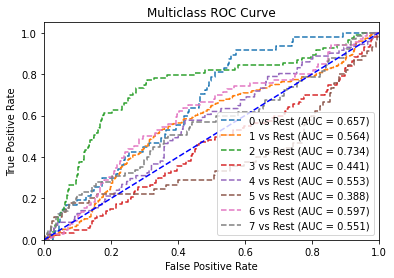

In [51]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [52]:
evaluate_recognition_rate(prediction)

Summation of patient score:  10.894606603833719
Total Number of Patients:  28
Recognition Rate:  0.38909309299406136


### **SVM**

In [74]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(probability=True, kernel= 'rbf', gamma=0.001, C=100)) #radial basis function kernel
                 ])

In [75]:
pipe1.fit(train_for_ML, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', SVC(C=100, gamma=0.001, probability=True))])

**Accuracy**

In [76]:
# Test set evaluation
prediction = pipe1.predict(test_for_ML)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 42.37%


**Area Under Curve**

In [77]:
prediction_prob = pipe1.predict_proba(test_for_ML)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.5816874870799407


In [78]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

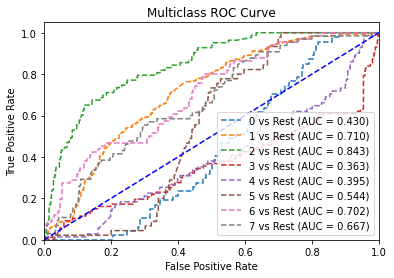

In [79]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [80]:
evaluate_recognition_rate(prediction)

Summation of patient score:  12.945060481003196
Total Number of Patients:  28
Recognition Rate:  0.46232358860725703


### **Random Forest**

In [96]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(n_estimators = 200, random_state = 42))
                 ])

In [97]:
pipe2.fit(train_for_ML,label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

**Accuracy**

In [98]:
# Test set evaluation
prediction = pipe2.predict(test_for_ML)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 41.45%


**Area Under Curve**

In [99]:
prediction_prob = pipe2.predict_proba(test_for_ML)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.5819897507173596


In [100]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

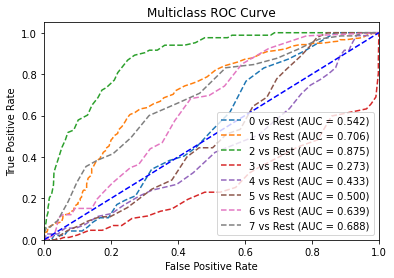

In [101]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [102]:
evaluate_recognition_rate(prediction)

Summation of patient score:  12.753916703157689
Total Number of Patients:  28
Recognition Rate:  0.4554970251127746


### **KNN**

In [142]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=21))
                 ])

In [143]:
pipe3.fit(train_for_ML,label_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=21))])

**Accuracy**

In [144]:
# Test set evaluation
prediction = pipe3.predict(test_for_ML)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 36.05%


**Area Under Curve**

In [145]:
prediction_prob = pipe3.predict_proba(test_for_ML)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.5057209697882703


In [146]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

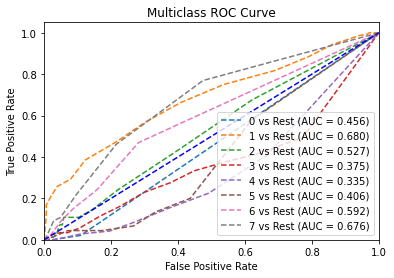

In [147]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [148]:
evaluate_recognition_rate(prediction)

Summation of patient score:  11.222107192107194
Total Number of Patients:  28
Recognition Rate:  0.4007895425752569


### **AdaBoost**

In [157]:
clf = AdaBoostClassifier(n_estimators=10, random_state=0)
clf.fit(train_for_ML,label_train)

AdaBoostClassifier(n_estimators=10, random_state=0)

**Accuracy**

In [158]:
# Test set evaluation
prediction = clf.predict(test_for_ML)
print('Accuracy: {0:5.2f}%'.format(accuracy_score(label_test,prediction)*100))

Accuracy: 30.92%


**Area Under Curve**

In [159]:
prediction_prob = clf.predict_proba(test_for_ML)
print("area under curve (AUC): ", roc_auc_score(label_test, prediction_prob, multi_class='ovr'))

area under curve (AUC):  0.5159456571609896


In [160]:
label_test_binarized = label_binarize(label_test, classes = np.unique(label_test))
classes = np.unique(label_test)
n_class = classes.shape[0]

fpr = {}
tpr = {}
thresh = {}
roc_auc = dict()

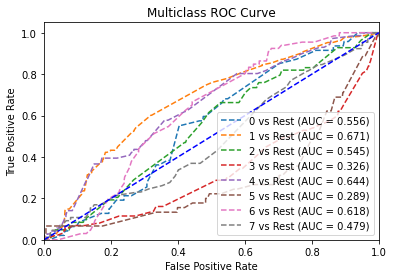

In [161]:
for i in range(n_class):
  fpr[i], tpr[i], thresh[i] = roc_curve(label_test_binarized[:,i], prediction_prob[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  #plotting
  plt.plot(fpr[i],tpr[i], linestyle = '--', 
           label = '%s vs Rest (AUC = %0.3f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

**Patient Recognition Rate**

In [162]:
evaluate_recognition_rate(prediction)

Summation of patient score:  9.318741851770337
Total Number of Patients:  28
Recognition Rate:  0.33281220899179775
